### 1/P^2 OPTIMAL DOLLAR COST AVERAGING STRATEGY

     1/P² OPTIMAL DCA – PRICE FALLING LEFT TO RIGHT (INR)

                     FINAL TRADING PLAN – PRICE FALLING LEFT TO RIGHT
 Price (₹)  Target Capital (₹)  Shares Bought  Actual Cost (₹)  Cumulative Shares  Running ACP (₹)
    100.00             4542.47             45          4500.00                 45         100.0000
     92.59             5298.63             54          4999.86                 99          95.9582
     85.72             6181.98             65          5571.80                164          91.9004
     79.37             7210.73             77          6111.49                241          87.8969
     73.49             8410.76             90          6614.10                331          83.9796
     68.04             9812.13            104          7076.16                435          80.1688
     63.00            11444.87            118          7434.00                553          76.5053
     58.33            13350.82            132          7699.56                6

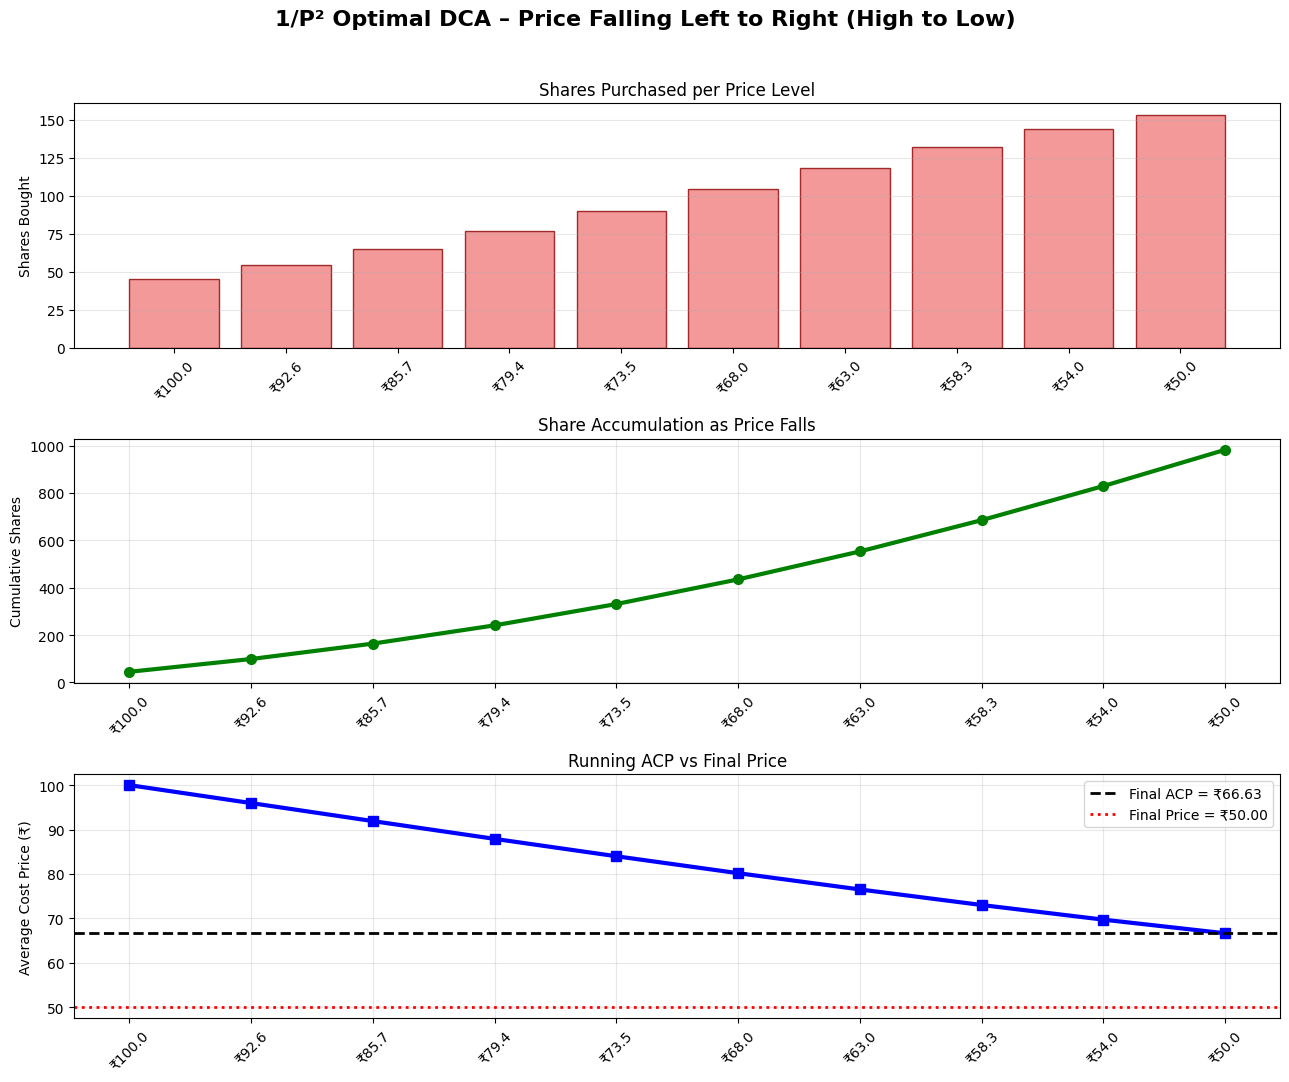

Thank you! Trade smarter as prices fall.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ===============================================================
# Helper Functions
# ===============================================================
def get_input(
    prompt, cast_func=float, condition=lambda x: True, error_msg="Invalid input"
):
    """Generic input helper for validated numeric input."""
    while True:
        try:
            value = cast_func(input(prompt))
            if condition(value):
                return value
            else:
                print(error_msg)
        except ValueError:
            print("Please enter a valid number.")


def get_user_inputs():
    """Collect and validate all user inputs."""
    print("=" * 70)
    print("     1/P² OPTIMAL DCA – PRICE FALLING LEFT TO RIGHT (INR)")
    print("=" * 70)

    total_capital = get_input(
        "\nEnter total capital to invest (e.g., 100000): ₹",
        float,
        lambda x: x > 0,
        "Capital must be positive.",
    )

    n_steps = get_input(
        "Enter number of buy steps (e.g., 8): ",
        int,
        lambda x: x >= 2,
        "Steps must be at least 2.",
    )

    initial_price = get_input(
        "Enter initial (highest) price: ₹",
        float,
        lambda x: x > 0,
        "Price must be positive.",
    )

    final_price = get_input(
        "Enter final (lowest) price: ₹",
        float,
        lambda x: x > 0,
        "Price must be positive.",
    )

    if initial_price <= final_price:
        print("Initial price must be greater than final price.")
        return get_user_inputs()

    sell_price = get_input(
        "Enter target sell price for profit simulation: ₹",
        float,
        lambda x: x > 0,
        "Sell price must be positive.",
    )

    return total_capital, n_steps, initial_price, final_price, sell_price


# ===============================================================
# Core Computation
# ===============================================================
def compute_dca_strategy(
    total_capital, n_steps, initial_price, final_price, sell_price
):
    """Compute full DCA simulation results and metrics."""

    # --- Price Grid (High → Low) ---
    prices = np.round(
        np.logspace(np.log10(initial_price), np.log10(final_price), n_steps), 2
    )

    # --- 1/P² Weights ---
    inv_p2 = 1 / (prices**2)
    weights = inv_p2 / inv_p2.sum()

    # --- Execute Trades ---
    remaining_capital = total_capital
    shares_bought, capital_used, cum_shares, running_acp = [], [], [], []

    total_shares = 0
    total_cost = 0

    for price, weight in zip(prices, weights):
        target_capital = remaining_capital * weight
        max_shares = int(target_capital // price)
        actual_cost = max_shares * price
        remaining_capital -= actual_cost

        total_shares += max_shares
        total_cost += actual_cost

        shares_bought.append(max_shares)
        capital_used.append(actual_cost)
        cum_shares.append(total_shares)
        running_acp.append(total_cost / total_shares if total_shares > 0 else price)

    # --- Metrics ---
    final_acp = total_cost / total_shares if total_shares > 0 else 0
    unutilized = total_capital - total_cost
    profit = total_shares * (sell_price - final_acp)
    profit_pct = (profit / total_capital) * 100 if total_capital > 0 else 0
    portfolio_value_at_final = total_shares * final_price
    loss_if_stuck = portfolio_value_at_final - total_cost
    loss_pct = (loss_if_stuck / total_cost) * 100 if total_cost > 0 else 0

    df = pd.DataFrame(
        {
            "Price (₹)": prices,
            "Target Capital (₹)": np.round(total_capital * weights, 2),
            "Shares Bought": shares_bought,
            "Actual Cost (₹)": capital_used,
            "Cumulative Shares": cum_shares,
            "Running ACP (₹)": np.round(running_acp, 4),
        }
    )

    summary = {
        "total_cost": total_cost,
        "unutilized": unutilized,
        "total_shares": total_shares,
        "final_acp": final_acp,
        "profit": profit,
        "profit_pct": profit_pct,
        "loss_if_stuck": loss_if_stuck,
        "loss_pct": loss_pct,
        "portfolio_value_at_final": portfolio_value_at_final,
    }

    return df, summary


# ===============================================================
# Display / Output
# ===============================================================
def display_dca_summary(df, summary, sell_price, final_price):
    """Print formatted results and summary to console."""
    print("\n" + "=" * 95)
    print("                     FINAL TRADING PLAN – PRICE FALLING LEFT TO RIGHT")
    print("=" * 95)
    print(df.to_string(index=False))

    print("\n" + "-" * 95)
    print(f"TOTAL CAPITAL COMMITTED       : ₹{summary['total_cost']:,.2f}")
    print(f"UNUTILIZED CAPITAL            : ₹{summary['unutilized']:,.2f}")
    print(f"TOTAL SHARES ACQUIRED         : {summary['total_shares']:,}")
    print(f"FINAL AVERAGE COST PRICE      : ₹{summary['final_acp']:,.4f}")
    print(
        f"PROFIT if sold at ₹{sell_price:,.2f}    : ₹{summary['profit']:,.2f} ({summary['profit_pct']:+.2f}%)"
    )
    print(
        f"PORTFOLIO VALUE at ₹{final_price:,.2f}   : ₹{summary['portfolio_value_at_final']:,.2f}"
    )
    print(
        f"LOSS IF PRICE STAYS at ₹{final_price:,.2f} : ₹{summary['loss_if_stuck']:,.2f} ({summary['loss_pct']:+.2f}%)"
    )
    print("-" * 95)


# ===============================================================
# Visualization
# ===============================================================
def plot_dca_results(df, final_acp, final_price):
    """Plot 3-panel visualization of DCA performance."""
    prices = df["Price (₹)"].values
    x_labels = [f"₹{p:,.1f}" for p in prices]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13, 11), dpi=100)
    fig.suptitle(
        "1/P² Optimal DCA – Price Falling Left to Right (High to Low)",
        fontsize=16,
        fontweight="bold",
    )

    # --- Plot 1: Shares Bought ---
    ax1.bar(
        range(len(prices)),
        df["Shares Bought"],
        color="lightcoral",
        edgecolor="darkred",
        alpha=0.8,
    )
    ax1.set_ylabel("Shares Bought")
    ax1.set_title("Shares Purchased per Price Level")
    ax1.set_xticks(range(len(prices)))
    ax1.set_xticklabels(x_labels, rotation=45)
    ax1.grid(True, axis="y", alpha=0.3)

    # --- Plot 2: Cumulative Shares ---
    ax2.plot(
        range(len(prices)),
        df["Cumulative Shares"],
        marker="o",
        color="green",
        linewidth=3,
        markersize=7,
    )
    ax2.set_ylabel("Cumulative Shares")
    ax2.set_title("Share Accumulation as Price Falls")
    ax2.set_xticks(range(len(prices)))
    ax2.set_xticklabels(x_labels, rotation=45)
    ax2.grid(True, alpha=0.3)

    # --- Plot 3: Running ACP ---
    ax3.plot(
        range(len(prices)),
        df["Running ACP (₹)"],
        marker="s",
        color="blue",
        linewidth=3,
        markersize=7,
    )
    ax3.axhline(
        final_acp,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Final ACP = ₹{final_acp:,.2f}",
    )
    ax3.axhline(
        final_price,
        color="red",
        linestyle=":",
        linewidth=2,
        label=f"Final Price = ₹{final_price:,.2f}",
    )
    ax3.set_ylabel("Average Cost Price (₹)")
    ax3.set_title("Running ACP vs Final Price")
    ax3.set_xticks(range(len(prices)))
    ax3.set_xticklabels(x_labels, rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# ===============================================================
# CLI Orchestration
# ===============================================================
def run_dca_cli():
    """Interactive CLI driver for the 1/P² DCA simulation."""
    while True:
        params = get_user_inputs()
        total_capital, n_steps, initial_price, final_price, sell_price = params

        df, summary = compute_dca_strategy(
            total_capital, n_steps, initial_price, final_price, sell_price
        )
        display_dca_summary(df, summary, sell_price, final_price)
        plot_dca_results(df, summary["final_acp"], final_price)

        again = input("\nRun again with new parameters? (y/n): ").strip().lower()
        if again != "y":
            print("Thank you! Trade smarter as prices fall.")
            break


# ===============================================================
# MAIN
# ===============================================================
if __name__ == "__main__":
    run_dca_cli()